In [1]:
import pandas as pd
from pandas import DataFrame
import pandas_datareader

def normalizeFeatures(filename):
	features = pd.read_csv(filename)
	normalized = pd.read_csv(filename)
	features.mean()
	features.std()
	normalized['favorite_count'] = (features['favorite_count'] - features.mean()[0])/features.std()[0]
	normalized['followers_count'] = (features['followers_count'] - features.mean()[1])/features.std()[1]
	normalized['friends_count'] = (features['friends_count'] - features.mean()[1])/features.std()[1]
	normalized['statuses_count'] = (features['statuses_count'] - features.mean()[2])/features.std()[2]
	normalized['retweet_count'] = (features['retweet_count'] - features.mean()[4])/features.std()[4]
	normalized['Fr_Fo_Ratio'] = (features['Fr_Fo_Ratio'] - features.mean()[10])/features.std()[10]
	normalized['St_Fo_Ratio'] = (features['Fr_Fo_Ratio'] - features.mean()[11])/features.std()[11]
	normalized.to_csv('csv/MoreNormalized.csv')

In [1]:
# Random Forest Algorithm on Sonar Dataset
from random import seed
from random import randrange
from csv import reader
from math import sqrt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1)
	return root

# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)

# Test the random forest algorithm
seed(2)
# load and prepare data
filename = 'csv/4Normalized.csv'
dataset = load_csv(filename)
# convert string attributes to integers
for i in range(0, len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1, 5, 10]:
	scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	print('Scores: %s' % scores)
	print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

ValueError: could not convert string to float: 'C'

In [176]:
datasett = pd.read_csv("csv/MoreFeatures.csv")

In [182]:
import pandas as pd
from pandas import DataFrame
import pandas_datareader
import twython
from twython import Twython

APP_KEY = ''
APP_SECRET = ''
ACCESS_TOKEN = ''

d = {'id':'', 'created_at':'', 'from_user':'', 'followers_count':'', 'friends_count':'', 'statuses_count':'', 'verified':'', 'location':'', 'text':'', 'retweet_count':'', 'favorite_count':'', 'hashtag_count':'', 'url_count':'', 'mentions_count':'', 'links':''}

def getFeatures(filename):
	csvfile = pd.read_csv(filename) #Reading .csv files containing tweets.
	tweet_ids = csvfile['id_str']	#Copying the 'id_str' attribute values to a item.
	length = len(tweet_ids)			#Getting the length of 'tweet_ids'.
	
	df = DataFrame(d, index=[0])	#Creating a DataFrame

	twitter = Twython(APP_KEY, APP_SECRET, oauth_version=2)
	ACCESS_TOKEN = twitter.obtain_access_token()
	twitter = Twython(APP_KEY, access_token=ACCESS_TOKEN)
	#Generating Access Token

	for i in range(0, length):
		status = twitter.show_status(id=tweet_ids[i])
		d['id'] = status['id_str'].encode('utf-8')
		d['created_at'] = status['created_at'].encode('utf-8')
		d['from_user'] = status['user']['screen_name'].encode('utf-8')
		d['followers_count'] = status['user']['followers_count']
		d['friends_count'] = status['user']['friends_count']
		d['statuses_count'] = status['user']['statuses_count']
		d['verified'] = status['user']['verified']
		d['location'] = 0 if (len(status['user']['location'].encode('utf-8'))==0) else 1
		d['text'] = status['text'].encode('utf-8')
		d['retweet_count'] = status['retweet_count']
		d['favorite_count'] = status['favorite_count']
		d['hashtag_count'] = len(status['entities']['hashtags'])
		d['url_count'] = len(status['entities']['urls'])
		d['mentions_count'] = len(status['entities']['user_mentions'])
		if(len(status['entities']['urls'])>0):
    			for x in range(0, len(status['entities']['urls'])):
       				d['links'] += status['entities']['urls'][x]['expanded_url'].encode('utf-8') + "  "
		df = df.append(d, ignore_index=True)
		df.to_csv('NSamples.csv') #Saving file to disk
		d['links'] = ''
	print ("\nAll Done!")

ModuleNotFoundError: No module named 'twython'

In [183]:
import pandas as pd  
import numpy as np  

In [184]:
dataset = pd.read_csv("csv/3MoreFeatures.csv")


In [195]:
datasett.head()


,label,followers_count,friends_count,statuses_count,other_social_media_count,hashtag_count,length_of_screen_name,length_of_description,url_count,verified,location,Fr_Fo_Ratio,St_Fo_Ratio
0,HC,2842,1648,131900,1,14,0,1,1,0,0,0.579873,46.410978
1,HC,3211,7,79448,0,7,0,1,1,0,1,0.002180,24.742448
2,HC,3211,7,79448,0,14,1,1,0,0,1,0.002180,24.742448
3,C,134990,438,31596,0,11,1,1,1,0,1,0.003245,0.234062
4,C,61019,485,299677,0,0,0,1,1,0,1,0.007948,4.911208


In [186]:
X = dataset.iloc[:, 0:4].values  
y = dataset.iloc[:, 4].values  

In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [188]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

/home/yellowwoods/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/yellowwoods/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/yellowwoods/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [189]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)  
 


In [190]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Scores:', metrics.mean_squared_error(y_test, y_pred))  
print('Mean Accuracy:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))*100)  


Mean Absolute Error: 0.5297319688109162
Scores: 0.600571955544726
Mean Accuracy: 77.49657770151698


In [198]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Count of each label in the dataset')

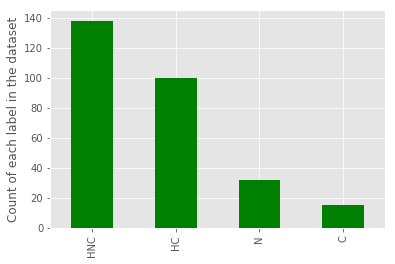

In [225]:
label_count = datasett['label'].value_counts()[:20]    
label_count.plot('bar',color = 'green')
plt.ylabel('Count of each label in the dataset')



In [ ]:
import numpy as np

In [232]:
datasett['label_pred'] = ['HC' if 'followers_count'>1000 'N' else if  'followers_count'<1000 && 'followers_count'>500 && 'friends_count'>1000 && 'statuses_count'> 10000 else 'N' 'followers_count'<500]

SyntaxError: invalid syntax (<ipython-input-232-4716168549c0>, line 1)